In [ ]:
#!pip3 install --user matplotlib

import sys
#sys.modules[__name__].__dict__.clear()

import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import sparse
from sklearn import linear_model
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA


In [88]:
aside=np.array([mpimg.imread(x) for x in glob.glob('/nfs/general/shared/KeyA/*.jpg')])
bside=np.array([mpimg.imread(x) for x in glob.glob('/nfs/general/shared/KeyD/*.jpg')])
y=np.zeros(aside.shape[0] + bside.shape[0])
y[:aside.shape[0]]=1.0
y[aside.shape[0]:]=0.0
X=np.concatenate((aside,bside),axis=0)
X=X.reshape(X.shape[0],-1)
kImgShape=aside.shape[1:]

def XtoImgShape(Xline):
    return Xline.reshape(aside.shape[1:])

def PlotSparseness(x):
    plt.imshow(np.where(x!=0,255,0), interpolation='nearest')
    
def GenSingleChannelDicts(s, windowSizes):
    for windowSize in windowSizes:
        for x in range(0, s[0], windowSize):
            for y in range(0, s[1], windowSize):
                r=np.zeros(s)
                r[x:x+windowSize,y:y+windowSize]=1
                yield r

def SpreadAcrossColors(mask):
    for i in [0,1,2]:
        r=np.zeros((*mask.shape,3))
        r[:,:,i]=mask
        yield r

def GenDict(s, windowSize):
    for d in GenSingleChannelDicts(s, windowSize):
        for m in SpreadAcrossColors(d):
            yield m

def GenDictSize(s, windowSize):
    size=0
    for d in GenSingleChannelDicts(s, windowSize):
        for m in SpreadAcrossColors(d):
            size += 1
    return size


In [21]:
GenDictSize(kImgShape[:2],[32])


900

In [ ]:
sparse_mats=[sparse.coo_matrix(x.astype(np.float32).reshape((-1,1))) for x in GenDict(kImgShape[:2],[8,16,32])]
proj=sparse.hstack(sparse_mats)
Xp=X.dot(proj)

In [22]:
#proj=np.array([x for x in GenDict(kImgShape[:2],[16,32])])
#Xp=np.matmul(X, proj.reshape((proj.shape[0],-1)).transpose())
#proj=sparse.hstack([sparse.csr_matrix(x.astype(np.float32).reshape((-1,1))) for x in GenDict(kImgShape[:2],[8,16,32])], format='csr')

#Xp=np.matmul(X, proj)
Xp=X

# foo=PCA(n_components=2).fit_transform(Xp.transpose())
# plt.scatter(foo[:,0],foo[:,1],color='r')
# plt.scatter(foo[:10,0],foo[:10,1],color='g')


#clf = linear_model.Lasso(alpha=0.1)
#clf.fit(X,y)

eps = 1e-3
#alphas_lasso, coefs_lasso, coefs = linear_model.lasso_path(X,Y, eps=eps, verbose=True,  alphas=np.logspace(-4, 1, 10))

alphas_lasso, coefs_lasso, coefs = linear_model.lasso_path(Xp,y,eps=eps, verbose=True,  alphas=np.logspace(-4, 4, 10))

#alphas_lars, coefs_lars, coefs = linear_model.lars_path(X, y, method="lasso", verbose=True)
#alphas_lars

...../home/geli/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.491e-01, tolerance: 1.600e-03
  model = cd_fast.enet_coordinate_descent(
./home/geli/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.577e-02, tolerance: 1.600e-03
  model = cd_fast.enet_coordinate_descent(
./home/geli/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.0

In [26]:
coefs

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.32087102e-07,
       5.96507338e-06, 1.81840436e-03, 9.24048252e-04, 1.29374734e-04,
       1.91713397e-05, 3.58130254e-06])

In [71]:
from sklearn.linear_model import OrthogonalMatchingPursuit

reg = OrthogonalMatchingPursuit(normalize=False, n_nonzero_coefs=100).fit(X, y)

/home/geli/.local/lib/python3.8/site-packages/sklearn/linear_model/_omp.py:419: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(


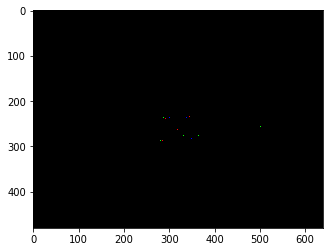

In [80]:
PlotSparseness(XtoImgShape(reg.coef_))

In [114]:
a=array.array('l')
a.fromlist(list(kImgShape)+[reg.n_nonzero_coefs])
a.tobytes()

b'\xe0\x01\x00\x00\x00\x00\x00\x00\x80\x02\x00\x00\x00\x00\x00\x00\x03\x00\x00\x00\x00\x00\x00\x00d\x00\x00\x00\x00\x00\x00\x00'

In [113]:
import array
reshapedCoefs=reg.coef_.reshape(kImgShape)
x_,y_,c_=np.nonzero(reshapedCoefs)
coefs_=reshapedCoefs[x_,y_,c_]



def SaveModel(reg, fname):
    import array
    reshapedCoefs=reg.coef_.reshape(kImgShape)
    x_,y_,c_=np.nonzero(reshapedCoefs)
    coefs_=reshapedCoefs[x_,y_,c_]
    f=open(fname,'wb')
    sizeArray=array.array('l')
    sizeArray.fromlist(list(kImgShape)+[reg.n_nonzero_coefs])
    f.write(sizeArray.tobytes())

    indexArray=array.array('l')
    indexArray.fromlist(list(x_)+list(y_)+list(c_))
    f.write(indexArray.tobytes())

    coefArray=array.array('f')
    coefArray.append(reg.intercept_)
    coefArray.extend(list(coefs_))
    f.write(coefArray.tobytes())
    f.close()


#     f.close()


#X.dot(reg.coef_)
# lambda_max=np.max(np.abs(X.transpose().dot(y)))/y.size
# print(lambda_max)
# l=linear_model.Lasso(alpha=lambda_max*0.01)
# r=l.fit(X,y)


#np.sum(coefs_lasso[:,-1] != 0.0)
#PlotSparseness(XtoImgShape(coefs_lasso[:,-1]))

#coefs_lasso.shape

#plt.imshow(np.max(proj[coefs_lasso[:,2]!=0,:,:,:],axis=0), interpolation='nearest')
#print('num coefs={}'.format(np.sum(np.abs(l.coef_) > 0.0)))

# PlotSparseness(XtoImgShape(X[0,:]))

#len(coefs_)



100

In [ ]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

#plt.imshow(np.max(proj[coefs_lasso[:,1]!=0,:,:,:],axis=0), interpolation='nearest')

#coefs_lasso[coefs_lasso[:,1]!=0,1]

In [ ]:
x=x.tocsc()

In [ ]:
#np.sum(coefs_lasso!=0,axis=0)

In [ ]:
#help(linear_model.lasso_path)

In [ ]:
#from sklearn.decomposition import sparse_encode 

In [ ]:
#help(sparse_encode)

In [ ]:
# from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA

# reduced_data = PCA(n_components=2).fit_transform(X)

In [ ]:
# plt.scatter(reduced_data[:,0],reduced_data[:,1],color='r')
# plt.scatter(reduced_data[:10,0],reduced_data[:10,1],color='b')

In [ ]:
BASE_DIR='/nfs/general/shared'
A_FILES=glob.glob('{}/KeyA/*.jpg'.format(BASE_DIR))
D_FILES=glob.glob('{}/KeyD/*.jpg'.format(BASE_DIR))
[x.replace(BASE_DIR, '') for x in  D_FILES]
